In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, imagenames in os.walk('/kaggle/input'):
    for filename in imagenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif
/kaggle/input

In [2]:
!pip install -qqq segmentation-models-pytorch
!pip install -qqq torchmetrics

In [3]:
#importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob

import gc
import time

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import time
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from IPython.display import Image
from skimage import io

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

from pprint import pprint

from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

from PIL import Image

import torchvision
from torchvision import transforms

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
#meta data
img_data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv') 
img_data.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [5]:
img_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [6]:
img_data.shape

(110, 18)

In [7]:
#extracting data from the original dataset
data_loc = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            mask_path = sub_dir_path + '/' + filename
            data_loc.extend([dir_name, mask_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [8]:
#separating imagename and mask path
imagenames = data_loc[::2]
masks = data_loc[1::2]

In [9]:
df = pd.DataFrame(data={"patient_id": imagenames,"img_path": masks})
print(df.shape)
df

(7858, 2)


patient_id                                           img_path
0     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
...                     ...                                                ...
7853  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7854  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7855  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7856  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
7857  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

[7858 rows x 2 columns]

In [10]:
# splitting which contains maska and does not contain mask
original_img = df[~df['img_path'].str.contains("mask")]
img_mask = df[df['img_path'].str.contains("mask")]

In [11]:
#printing original image and mask
original_img, img_mask

(                 patient_id                                           img_path
 0     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 2     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 3     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 4     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 5     TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 ...                     ...                                                ...
 7849  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7850  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7852  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7854  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 7856  TCGA_DU_7306_19930512  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
 
 [3929 rows x 2 columns],
            

In [12]:
#sorting images and mask
imgs = sorted(original_img["img_path"].values, key=lambda x : int(x[89:-4]))
masks = sorted(img_mask["img_path"].values, key=lambda x : int(x[89:-9]))

# Sorting checking
idx = random.randint(0, len(imgs)-1)
print("Image path:", imgs[idx], "\nMask path:", masks[idx])

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_2.tif 
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_2_mask.tif


In [13]:
#combining data
mri_data = pd.DataFrame({"patient_id": original_img.patient_id.values,"img_path": imgs,
                           'mask_path':masks})
mri_data

patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                               img_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
...                                                 ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  

[3929 rows x 3 columns]

In [14]:
#calculating maximum pixel value using cv2
def get_diagnosis(img_path):
    value = np.max(cv2.imread(img_path))
    if value > 0 : 
        return 1
    else:
        return 0

In [15]:
mri_data.head()

patient_id                                           img_path  \
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [16]:
#applying the diagnosis function to mask_path column
mri_data['mask'] = mri_data['mask_path'].apply(lambda x: get_diagnosis(x))

mri_data['mask_path'] = mri_data['mask_path'].apply(lambda x: str(x))

print(mri_data.shape)
mri_data

(3929, 4)


patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                               img_path  \
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
...                                                 ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                              mask_path  mask  
0     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
1     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
2     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
4     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
...                                                 ...   ...  
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...     0  

[3929 rows x 4 columns]

In [17]:
#dropping patient_id column
mri_data.drop(columns=['patient_id'],inplace=True)

<Axes: title={'center': 'Count of Tumour vs No Tumour'}>

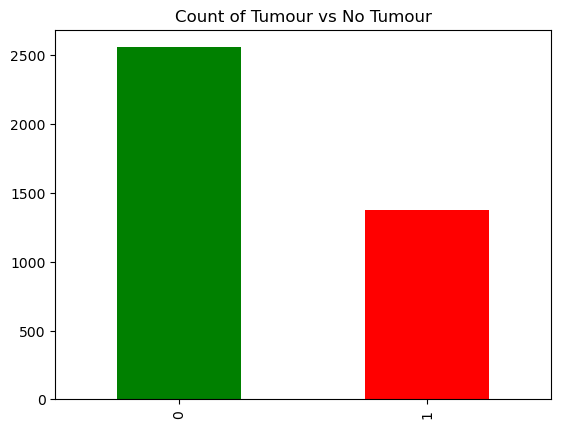

In [18]:
#visualizing data
mri_data['mask'].value_counts().plot(kind='bar',color=['g','r'],
                title='Count of Tumour vs No Tumour')

In [19]:
mri_data['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


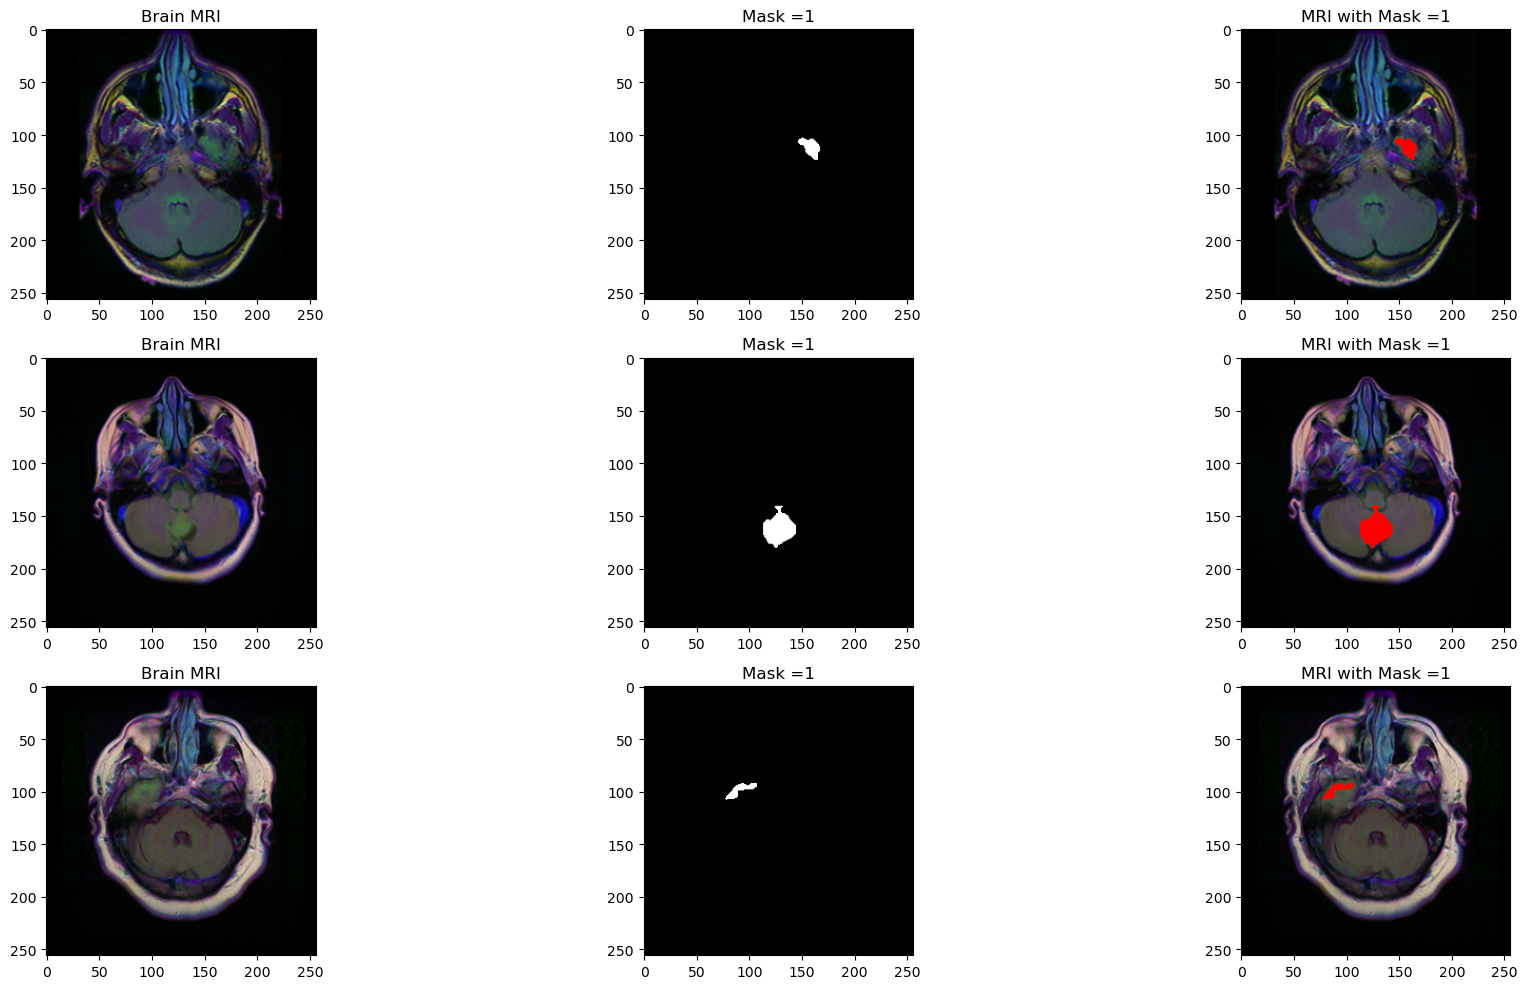

In [20]:
count = 0
i = 0
fig,axs = plt.subplots(3,3, figsize=(20,10))
for mask in mri_data['mask']:
    if (mask==1):
        img = io.imread(mri_data.img_path[i])
        print(img.shape)
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(mri_data.mask_path[i])
        axs[count][1].title.set_text("Mask =" + str(mri_data['mask'][i]))
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask =" + str(mri_data['mask'][i]))
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==3):
        break
        
fig.tight_layout()

#2nd column displays the mask image
#third column displays the MRI image with applied mask

In [21]:
#tranforms both image and mask
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),

])

mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    ])

In [22]:
#normalizing the image by dividing each pixel value by 255
def adjust_data(img, mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    
    return (img, mask)


In [23]:
class MyData(Dataset):
    def __init__(self, df= mri_data, 
                 adjust_data = adjust_data, 
                 image_transform=image_transform, mask_transform=mask_transform):
        self.df = df
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.adjust_data= adjust_data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.loc[idx, 'img_path']
        mask_path = self.df.loc[idx, 'mask_path']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#         _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        image, mask = self.adjust_data(image, mask)

        if self.image_transform:
            image = self.image_transform(image).float()

        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

In [24]:
index = 2911
data = MyData()[index]
data[0].shape, data[1].shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

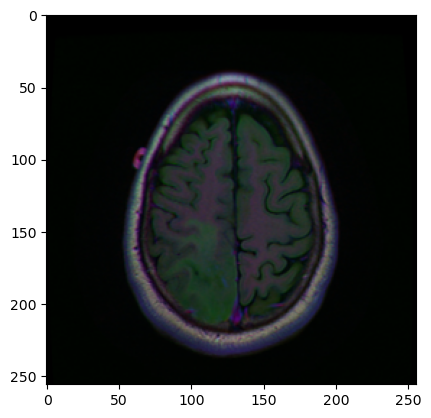

In [25]:
plt.imshow(data[0].permute(1, 2, 0).numpy())

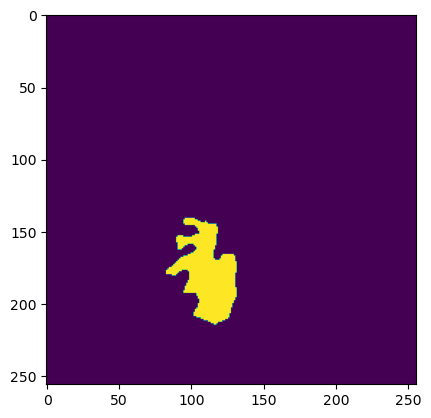

In [26]:
plt.imshow(data[1].permute(1, 2, 0).squeeze(-1).numpy())

In [27]:
np.unique(data[1])

array([0., 1.])

In [28]:
#creating data loaders block
def prepare_loaders(df= mri_data,
                    train_num= int(mri_data.shape[0] * .6), 
                    valid_num= int(mri_data.shape[0] * .8), 
                    bs = 32):
    
    train = df[:train_num].reset_index(drop=True)
    valid = df[train_num : valid_num].reset_index(drop=True)    
    test  = df[valid_num:].reset_index(drop=True)

    train_ds = MyData(df = train)
    valid_ds = MyData(df = valid)
    test_ds = MyData(df = test)

    train_loader = DataLoader(train_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = True)
    valid_loader = DataLoader(valid_ds, batch_size = bs, num_workers = os.cpu_count(), shuffle = False)
    test_loader = DataLoader(test_ds, batch_size = 4, num_workers = os.cpu_count(), shuffle = True)
    
    print("DataLoader Completed")
    
    return train_loader, valid_loader, test_loader

In [29]:

train_loader, valid_loader, test_loader = prepare_loaders()

DataLoader Completed


In [30]:
#printing shapes of tensor
data = next(iter(train_loader))
data[0].shape, data[1].shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 256, 256]))

In [31]:
#if GPU is available it'll run on GPU or else CPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [32]:
class Block(nn.Module):
    def __init__(self, inputs = 3, middles = 64, outs = 64):
        super().__init__()

        
        self.conv1 = nn.Conv2d(inputs, middles, 3, 1, 1)
        self.conv2 = nn.Conv2d(middles, outs, 3, 1, 1)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(outs)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.bn(self.conv2(x)))

        
        return self.pool(x), x
      

In [33]:
#Unet architecture
class UNet(nn.Module):
    def __init__(self,):
        super().__init__()

        
        self.en1 = Block(3, 64, 64)
        self.en2 = Block(64, 128, 128)
        self.en3 = Block(128, 256, 256)
        self.en4 = Block(256, 512, 512)
        self.en5 = Block(512, 1024, 512)
        
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride = 2)
        self.de4 = Block(1024, 512, 256)
        
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride = 2)
        self.de3 = Block(512, 256, 128)
        
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride = 2)
        self.de2 = Block(256, 128, 64)
        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.de1 = Block(128, 64, 64)
        
        self.conv_last = nn.Conv2d(64, 1, kernel_size=1, stride = 1, padding = 0)
        
    def forward(self, x):
        # x: [bs, 3, 256, 256]
        
        x, e1 = self.en1(x)
        x, e2 = self.en2(x)
        x, e3 = self.en3(x)
        x, e4 = self.en4(x)
        _, x = self.en5(x)
        
        x = self.upsample4(x)  # x: [bs, 512, 32, 32]
        
        x = torch.cat([x, e4], dim=1)    # x: [bs, 1024, 32, 32]
        
        _,  x = self.de4(x)      # x: [bs, 256, 32, 32]
        
        
        x = self.upsample3(x)      # x: [bs, 256, 64, 64]
        
        x = torch.cat([x, e3], dim=1)     # x: [bs, 512, 64, 64]
        
        _, x = self.de3(x)      # x: [bs, 128, 64, 64]
        
        
        x = self.upsample2(x)       # x: [bs, 128, 128, 128]
        
        x = torch.cat([x, e2], dim=1)        # x: [bs, 256, 128, 128]
        
        _, x = self.de2(x)         # x: [bs, 64, 128, 128]
        
        
        x = self.upsample1(x)           # x: [bs, 64, 256, 256]
        
        x = torch.cat([x, e1], dim=1)       # x: [bs, 128, 256,256, 256
        
        _, x = self.de1(x)       # x: [bs, 64, 256, 256]
        
        
        x = self.conv_last(x)        # x: [bs, 1, 256, 256]
       
        
                
        return x    # x = x.squeeze(1)  


In [34]:
model = UNet().to(device)
model

UNet(
  (en1): Block(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en2): Block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (en3): Block(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(256, eps=1e-05, momentum

In [35]:

loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 )

In [36]:
# Scheduler
from torch.optim import lr_scheduler

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200,eta_min = 1e-6)

In [37]:
#training function and tracking model's progress for 1 epoch
def train_one_epoch(model = model, 
                    dataloader = train_loader, 
                    loss_fn = loss_fn, 
                    optimizer = optimizer,
                    scheduler = None,
                    device = device, 
                    epoch = 1):
    model.train() 
    train_loss, dataset_size = 0,  0
    
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    for data in bar:
        x = data[0].to(device)     
        y_true = data[1].to(device) 
        y_pred = model(x)          
        
        loss = loss_fn(y_pred, y_true)
        
        pred_mask = (y_pred > 0.5).float()
        btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.shape[0]
        dataset_size += bs
        train_loss += (loss.item() * bs)
        train_epoch_loss = train_loss / dataset_size
        
        tp_l.append(btp)
        fp_l.append(bfp)
        fn_l.append(bfn)
        tn_l.append(btn)
        
        tp = torch.cat(tp_l)
        fp = torch.cat(fp_l)
        fn = torch.cat(fn_l)
        tn = torch.cat(tn_l)
        
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
        precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
        
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        
           # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
       # Dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        bar.set_description(f"EP:{epoch} | TL:{train_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")
        
    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    metrics['dataset_iou'] = dataset_iou.detach().cpu().item()
    metrics['per_iou'] = per_image_iou.detach().cpu().item()
    
    metrics['loss'] = train_epoch_loss

    return metrics

In [38]:
#validation function
@torch.no_grad()
def valid_one_epoch(model = model, 
                    dataloader = valid_loader, 
                    loss_fn = loss_fn,
                    device = device, 
                    epoch = 0):
    model.eval() 
    valid_loss, dataset_size = 0,  0
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    with torch.no_grad():
        for data in bar:
            x = data[0].to(device)     
            y_true = data[1].to(device) 
            y_pred = model(x)        
            
            loss = loss_fn(y_pred, y_true)
            
            pred_mask = (y_pred > 0.5).float()
            btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

            tp_l.append(btp)
            fp_l.append(bfp)
            fn_l.append(bfn)
            tn_l.append(btn)

            tp = torch.cat(tp_l)
            fp = torch.cat(fp_l)
            fn = torch.cat(fn_l)
            tn = torch.cat(tn_l)

            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

            # per image IoU means that we first calculate IoU score for each image 
            # and then compute mean over these scores
            per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

           # Dataset IoU means that we aggregate intersection and union over whole dataset
           # and then compute IoU score.
            dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            # valid_epoch_loss 
            bs = x.shape[0]
            dataset_size += bs
            valid_loss += (loss.item() * bs)
            valid_epoch_loss = valid_loss / dataset_size

            bar.set_description(f"EP:{epoch} | VL:{valid_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")

    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    metrics['dataset_iou'] = dataset_iou.detach().cpu().item()
    metrics['per_iou'] = per_image_iou.detach().cpu().item()
    
    metrics['loss'] = valid_epoch_loss

    return metrics

In [39]:
#training the model for multiple epochs
import copy

def run_training(model = model, 
                 loss_fn = loss_fn, 
                 train_loader = train_loader,
                 valid_loader = valid_loader,
                 optimizer = optimizer, 
                 device = device, 
                 n_epochs=100, 
                 early_stop = 20,
                 scheduler = None):

    if torch.cuda.is_available():
        print("INFO: GPU - {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    lowest_epoch, lowest_loss = np.inf, np.inf
    
    train_history, valid_history = [],  []
    train_recalls, valid_recalls = [],  []
    
    train_pres, valid_pres = [],  []
    train_accs, valid_accs = [],  []
    
    train_f1s, valid_f1s = [],  []
    
    train_per_ious, valid_per_ious = [], []
    train_dataset_ious, valid_dataset_ious = [], []
    
    print_iter = 5

    best_score = 0
    best_model = "None"

    for epoch in range(0, n_epochs):
        gc.collect()

        train_metrics = train_one_epoch(model= model,
                                       dataloader = train_loader,
                                       optimizer = optimizer,
                                       scheduler = scheduler,
                                       device = device,
                                       epoch = epoch + 1
                                       )
        
        valid_metrics = valid_one_epoch(model,
                                       dataloader = valid_loader,
                                       device = device,
                                       epoch = epoch + 1)
        
        
        train_history += [train_metrics['loss']]
        valid_history += [valid_metrics['loss']]
        
        train_recalls += [train_metrics['recall']]
        valid_recalls += [valid_metrics['recall']]
        
        train_pres += [train_metrics['precision']]
        valid_pres += [valid_metrics['precision']]
        
        train_accs += [train_metrics['accuracy']]
        valid_accs += [valid_metrics['accuracy']]
        
        train_f1s += [train_metrics['f1_score']]
        valid_f1s += [valid_metrics['f1_score']]
        
        train_per_ious += [train_metrics['per_iou']]
        valid_per_ious += [valid_metrics['per_iou']]
        
        train_dataset_ious += [train_metrics['dataset_iou']]
        valid_dataset_ious += [valid_metrics['dataset_iou']]
        
        
        print()
        if (epoch + 1) % print_iter == 0:
            print(f"Epoch:{epoch + 1}|TL:{train_metrics['loss']:.3e}|VL:{valid_metrics['loss']:.3e}|F1:{valid_metrics['f1_score']:.4f}|Dataset IOU:{valid_metrics['dataset_iou']:.4f}|Per Img IOU:{valid_metrics['per_iou']:.4f}|")
            print()
            
        if best_score < valid_metrics['f1_score']:
            print(f"Validation F1 Improved({best_score:.2f}) --> ({ valid_metrics['f1_score']:.2f})")
            best_model = model
            best_score = valid_metrics['f1_score']
            best_model = copy.deepcopy(model.state_dict())
            PATH2 =  f"model_f1.bin"
            torch.save(model.state_dict(), PATH2)
            print(f"Better_F1_Model Saved")
            print()

        if valid_metrics['loss']< lowest_loss:
            print(f"Validation Loss Improved({lowest_loss:.4e}) --> ({ valid_metrics['loss']:.4e})")
            lowest_loss = valid_metrics['loss']
            lowest_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"model.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Better Loss Model Saved")
            print()
        else:
            if early_stop > 0 and lowest_epoch + early_stop < epoch + 1:
                print("There is no improvement") #  meananing 'There is no improvement' 
                break
                
    print()
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: %.4e at %d th Epoch" % (lowest_loss, lowest_epoch))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    model.load_state_dict(torch.load('./model_f1.bin'))

    result = dict()
    result["Train Loss"] = train_history
    result["Valid Loss"] = valid_history
    
    result["Train Recall"] = train_recalls
    result["Valid Recall"] = valid_recalls
    
    result["Train Precision"] = train_pres
    result["Valid Precision"] = valid_pres
    
    result["Train Accuracy"] = train_accs
    result["Valid Accuracy"] = valid_accs
    
    result["Train F1 Score"] = train_f1s
    result["Valid F1 Score"] = valid_f1s
    
    result["Train per Image IOU"] = train_per_ious
    result["Valid per Image IOU"] = valid_per_ious
    
    result["Train Dataset IOU"] = train_dataset_ious
    result["Valid Dataset IOU"] = valid_dataset_ious
    
    return model, result

In [40]:
#training our model for n_epochs
model, result = run_training(model = model, 
                             loss_fn = loss_fn, 
                             optimizer = optimizer, 
                             device = device, 
                             scheduler = scheduler,
                             n_epochs = 30)

INFO: GPU - Tesla T4



EP:1 | TL:9.124e-01 | ACC: 0.95 | F1: 0.229 : 100%|██████████| 74/74 [01:50<00:00,  1.49s/it]
EP:1 | VL:8.854e-01 | ACC: 0.82 | F1: 0.143 : 100%|██████████| 25/25 [00:13<00:00,  1.87it/s]



Validation F1 Improved(0.00) --> (0.14)
Better_F1_Model Saved

Validation Loss Improved(inf) --> (8.8538e-01)
Better Loss Model Saved



EP:2 | TL:7.359e-01 | ACC: 0.99 | F1: 0.491 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:2 | VL:5.186e-01 | ACC: 0.99 | F1: 0.678 : 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]



Validation F1 Improved(0.14) --> (0.68)
Better_F1_Model Saved

Validation Loss Improved(8.8538e-01) --> (5.1859e-01)
Better Loss Model Saved



EP:3 | TL:6.011e-01 | ACC: 0.99 | F1: 0.668 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:3 | VL:4.907e-01 | ACC: 0.99 | F1: 0.712 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



Validation F1 Improved(0.68) --> (0.71)
Better_F1_Model Saved

Validation Loss Improved(5.1859e-01) --> (4.9073e-01)
Better Loss Model Saved



EP:4 | TL:5.665e-01 | ACC: 0.99 | F1: 0.681 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:4 | VL:8.085e-01 | ACC: 0.99 | F1: 0.258 : 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


EP:5 | TL:4.833e-01 | ACC: 0.99 | F1: 0.642 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:5 | VL:6.313e-01 | ACC: 0.96 | F1: 0.382 : 100%|██████████| 25/25 [00:13<00:00,  1.92it/s]



Epoch:5|TL:4.833e-01|VL:6.313e-01|F1:0.3820|Dataset IOU:0.2361|Per Img IOU:0.3610|



EP:6 | TL:3.795e-01 | ACC: 0.99 | F1: 0.666 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:6 | VL:3.012e-01 | ACC: 0.99 | F1: 0.709 : 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]



Validation Loss Improved(4.9073e-01) --> (3.0119e-01)
Better Loss Model Saved



EP:7 | TL:3.487e-01 | ACC: 0.99 | F1: 0.683 : 100%|██████████| 74/74 [01:45<00:00,  1.43s/it]
EP:7 | VL:2.957e-01 | ACC: 0.99 | F1: 0.708 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



Validation Loss Improved(3.0119e-01) --> (2.9566e-01)
Better Loss Model Saved



EP:8 | TL:2.933e-01 | ACC: 1.00 | F1: 0.733 : 100%|██████████| 74/74 [01:46<00:00,  1.43s/it]
EP:8 | VL:2.806e-01 | ACC: 0.99 | F1: 0.725 : 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



Validation F1 Improved(0.71) --> (0.72)
Better_F1_Model Saved

Validation Loss Improved(2.9566e-01) --> (2.8059e-01)
Better Loss Model Saved



EP:9 | TL:2.779e-01 | ACC: 1.00 | F1: 0.742 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:9 | VL:2.742e-01 | ACC: 0.99 | F1: 0.732 : 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



Validation F1 Improved(0.72) --> (0.73)
Better_F1_Model Saved

Validation Loss Improved(2.8059e-01) --> (2.7419e-01)
Better Loss Model Saved



EP:10 | TL:3.020e-01 | ACC: 1.00 | F1: 0.723 : 100%|██████████| 74/74 [01:45<00:00,  1.43s/it]
EP:10 | VL:3.268e-01 | ACC: 0.99 | F1: 0.672 : 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]



Epoch:10|TL:3.020e-01|VL:3.268e-01|F1:0.6715|Dataset IOU:0.5055|Per Img IOU:0.6306|



EP:11 | TL:3.103e-01 | ACC: 0.99 | F1: 0.708 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:11 | VL:3.056e-01 | ACC: 0.99 | F1: 0.699 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


EP:12 | TL:2.983e-01 | ACC: 0.99 | F1: 0.715 : 100%|██████████| 74/74 [01:46<00:00,  1.43s/it]
EP:12 | VL:2.838e-01 | ACC: 0.99 | F1: 0.716 : 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


EP:13 | TL:2.603e-01 | ACC: 1.00 | F1: 0.756 : 100%|██████████| 74/74 [01:46<00:00,  1.43s/it]
EP:13 | VL:2.606e-01 | ACC: 0.99 | F1: 0.741 : 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]



Validation F1 Improved(0.73) --> (0.74)
Better_F1_Model Saved

Validation Loss Improved(2.7419e-01) --> (2.6060e-01)
Better Loss Model Saved



EP:14 | TL:2.423e-01 | ACC: 1.00 | F1: 0.778 : 100%|██████████| 74/74 [01:46<00:00,  1.43s/it]
EP:14 | VL:2.681e-01 | ACC: 0.99 | F1: 0.734 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


EP:15 | TL:2.408e-01 | ACC: 1.00 | F1: 0.776 : 100%|██████████| 74/74 [01:46<00:00,  1.43s/it]
EP:15 | VL:2.897e-01 | ACC: 0.99 | F1: 0.710 : 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



Epoch:15|TL:2.408e-01|VL:2.897e-01|F1:0.7102|Dataset IOU:0.5507|Per Img IOU:0.6537|



EP:16 | TL:2.545e-01 | ACC: 1.00 | F1: 0.756 : 100%|██████████| 74/74 [01:45<00:00,  1.43s/it]
EP:16 | VL:2.727e-01 | ACC: 0.99 | F1: 0.730 : 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


EP:17 | TL:2.879e-01 | ACC: 1.00 | F1: 0.729 : 100%|██████████| 74/74 [01:45<00:00,  1.43s/it]
EP:17 | VL:3.112e-01 | ACC: 0.99 | F1: 0.696 : 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


EP:18 | TL:2.585e-01 | ACC: 1.00 | F1: 0.761 : 100%|██████████| 74/74 [01:46<00:00,  1.43s/it]
EP:18 | VL:2.595e-01 | ACC: 0.99 | F1: 0.744 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



Validation F1 Improved(0.74) --> (0.74)
Better_F1_Model Saved

Validation Loss Improved(2.6060e-01) --> (2.5952e-01)
Better Loss Model Saved



EP:19 | TL:2.176e-01 | ACC: 1.00 | F1: 0.795 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:19 | VL:2.466e-01 | ACC: 0.99 | F1: 0.756 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



Validation F1 Improved(0.74) --> (0.76)
Better_F1_Model Saved

Validation Loss Improved(2.5952e-01) --> (2.4665e-01)
Better Loss Model Saved



EP:20 | TL:2.096e-01 | ACC: 1.00 | F1: 0.800 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:20 | VL:2.508e-01 | ACC: 0.99 | F1: 0.751 : 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]



Epoch:20|TL:2.096e-01|VL:2.508e-01|F1:0.7514|Dataset IOU:0.6018|Per Img IOU:0.6374|



EP:21 | TL:2.267e-01 | ACC: 1.00 | F1: 0.794 : 100%|██████████| 74/74 [01:46<00:00,  1.43s/it]
EP:21 | VL:2.765e-01 | ACC: 0.99 | F1: 0.729 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


EP:22 | TL:2.673e-01 | ACC: 1.00 | F1: 0.753 : 100%|██████████| 74/74 [01:46<00:00,  1.43s/it]
EP:22 | VL:4.328e-01 | ACC: 0.99 | F1: 0.573 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


EP:23 | TL:2.321e-01 | ACC: 1.00 | F1: 0.773 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:23 | VL:2.604e-01 | ACC: 0.99 | F1: 0.745 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


EP:24 | TL:1.997e-01 | ACC: 1.00 | F1: 0.808 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:24 | VL:2.397e-01 | ACC: 0.99 | F1: 0.767 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]



Validation F1 Improved(0.76) --> (0.77)
Better_F1_Model Saved

Validation Loss Improved(2.4665e-01) --> (2.3971e-01)
Better Loss Model Saved



EP:25 | TL:1.882e-01 | ACC: 1.00 | F1: 0.822 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:25 | VL:2.323e-01 | ACC: 0.99 | F1: 0.776 : 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]



Epoch:25|TL:1.882e-01|VL:2.323e-01|F1:0.7756|Dataset IOU:0.6335|Per Img IOU:0.6640|

Validation F1 Improved(0.77) --> (0.78)
Better_F1_Model Saved

Validation Loss Improved(2.3971e-01) --> (2.3231e-01)
Better Loss Model Saved



EP:26 | TL:1.932e-01 | ACC: 1.00 | F1: 0.816 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:26 | VL:3.000e-01 | ACC: 0.99 | F1: 0.703 : 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]


EP:27 | TL:2.182e-01 | ACC: 1.00 | F1: 0.795 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:27 | VL:2.805e-01 | ACC: 0.99 | F1: 0.728 : 100%|██████████| 25/25 [00:12<00:00,  1.95it/s]


EP:28 | TL:2.171e-01 | ACC: 1.00 | F1: 0.793 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:28 | VL:2.455e-01 | ACC: 0.99 | F1: 0.757 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


EP:29 | TL:1.937e-01 | ACC: 1.00 | F1: 0.818 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:29 | VL:2.294e-01 | ACC: 0.99 | F1: 0.779 : 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]



Validation F1 Improved(0.78) --> (0.78)
Better_F1_Model Saved

Validation Loss Improved(2.3231e-01) --> (2.2941e-01)
Better Loss Model Saved



EP:30 | TL:1.800e-01 | ACC: 1.00 | F1: 0.824 : 100%|██████████| 74/74 [01:46<00:00,  1.44s/it]
EP:30 | VL:2.420e-01 | ACC: 0.99 | F1: 0.766 : 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


Epoch:30|TL:1.800e-01|VL:2.420e-01|F1:0.7662|Dataset IOU:0.6211|Per Img IOU:0.6928|


Training complete in 0h 59m 56s
Best Loss: 2.2941e-01 at 28 th Epoch


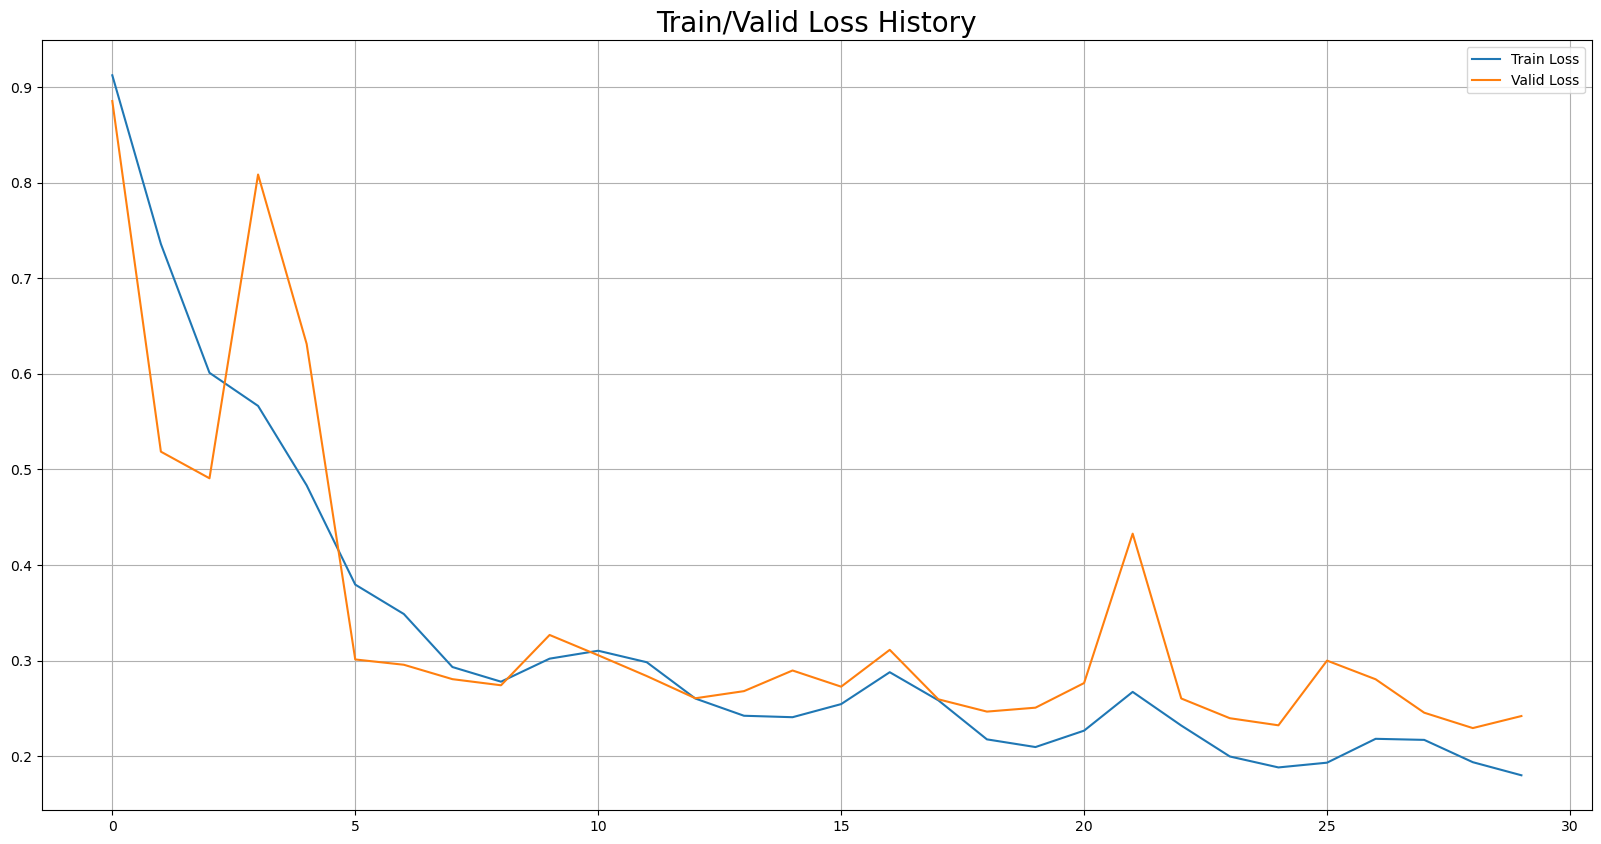

In [41]:
## Visualizing Train/Valid Loss History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Loss History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Loss'][plot_from:])), 
    result['Train Loss'][plot_from:], 
    label = 'Train Loss'
    )

plt.plot(
    range(0, len(result['Valid Loss'][plot_from:])), 
    result['Valid Loss'][plot_from:], 
    label = 'Valid Loss'
    )

plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()

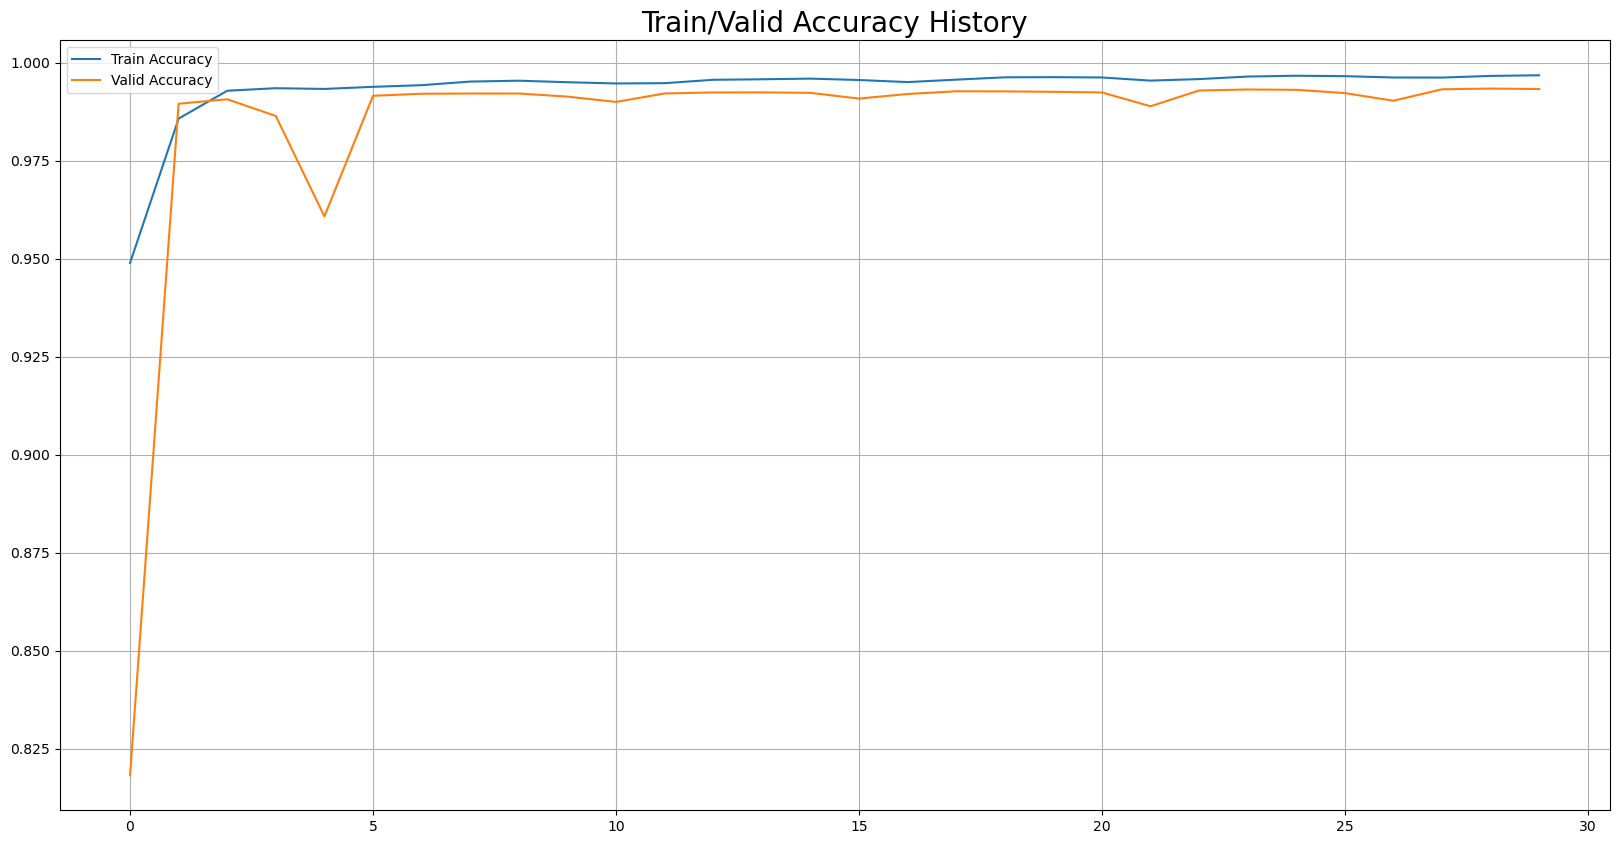

In [42]:
## Visualizing Train/Valid Accuracy History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Accuracy History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Accuracy'][plot_from:])), 
    result['Train Accuracy'][plot_from:], 
    label = 'Train Accuracy'
    )

plt.plot(
    range(0, len(result['Valid Accuracy'][plot_from:])), 
    result['Valid Accuracy'][plot_from:], 
    label = 'Valid Accuracy'
    )

plt.legend()

plt.grid(True)

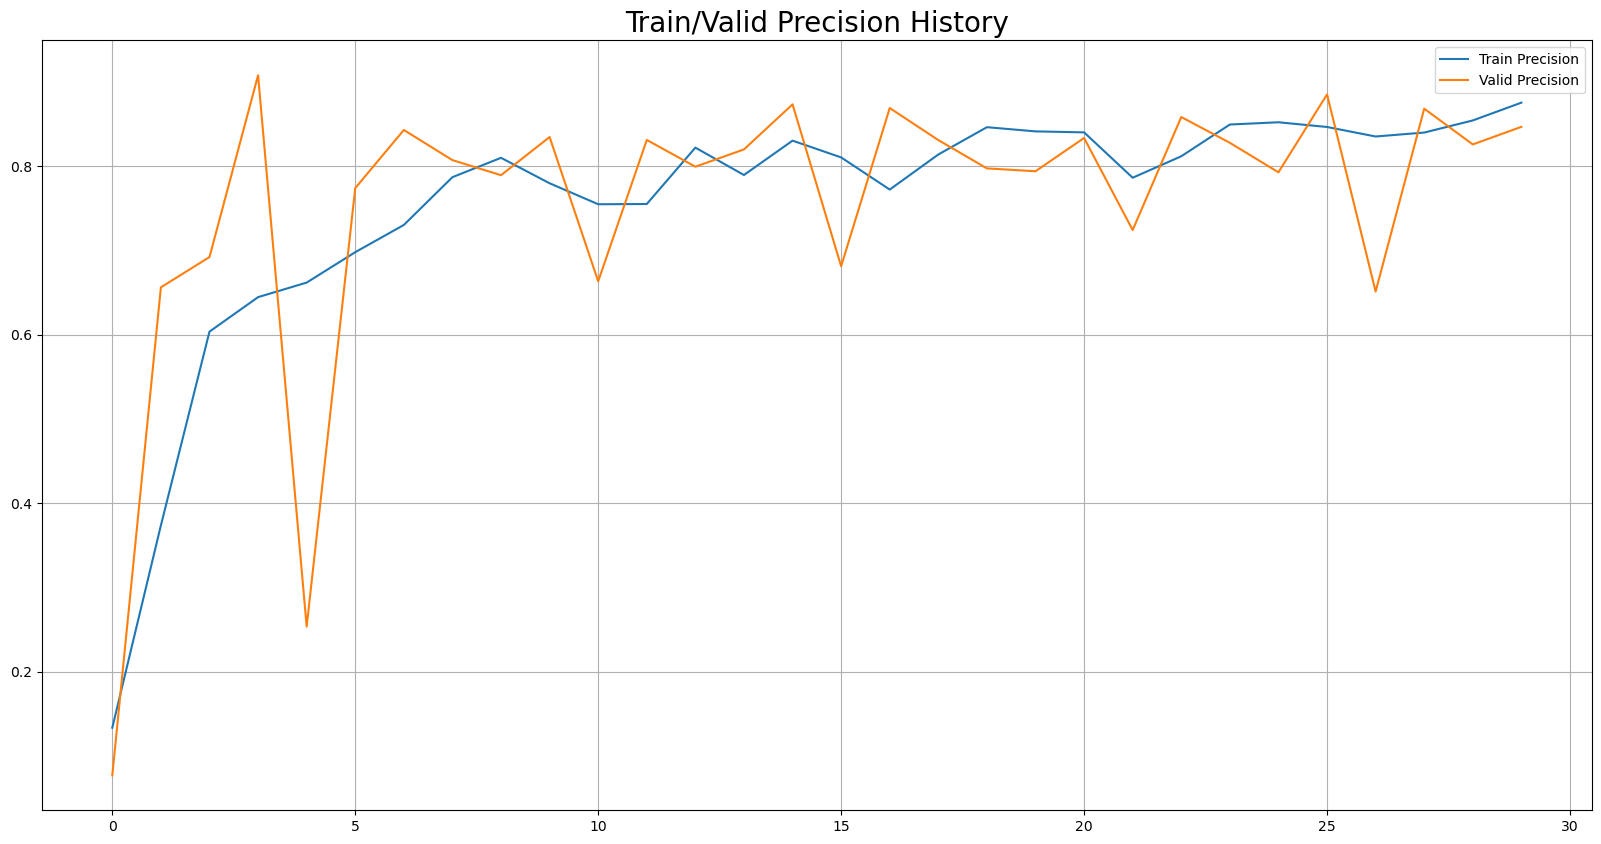

In [43]:
## Visualizing Train/Valid Precision History
plot_from = 0
plt.figure(figsize=(20, 10))
plt.title("Train/Valid Precision History", fontsize = 20)
plt.plot(
    range(0, len(result['Train Precision'][plot_from:])), 
    result['Train Precision'][plot_from:], 
    label = 'Train Precision'
    )

plt.plot(
    range(0, len(result['Valid Precision'][plot_from:])), 
    result['Valid Precision'][plot_from:], 
    label = 'Valid Precision'
    )

plt.legend()

plt.grid(True)

In [44]:
model.load_state_dict(torch.load('/kaggle/working/model_f1.bin'))

<All keys matched successfully>

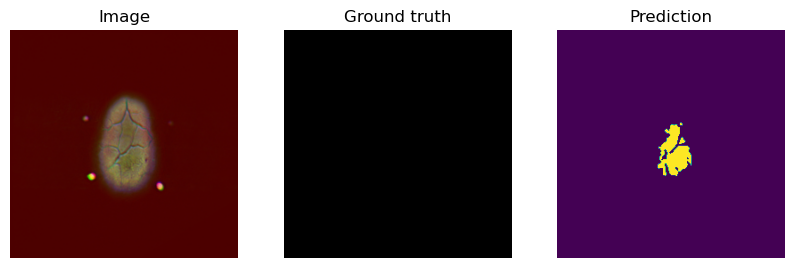

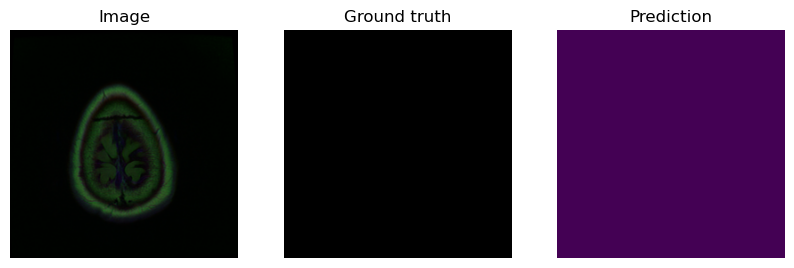

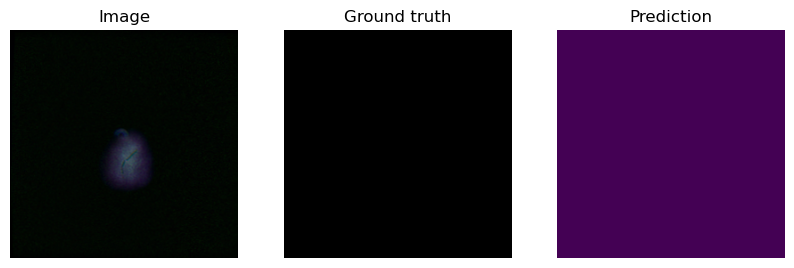

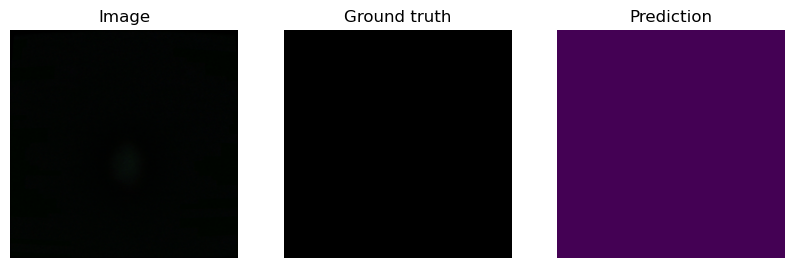

In [45]:
#Predicting the Images
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # we need to squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # we need to squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

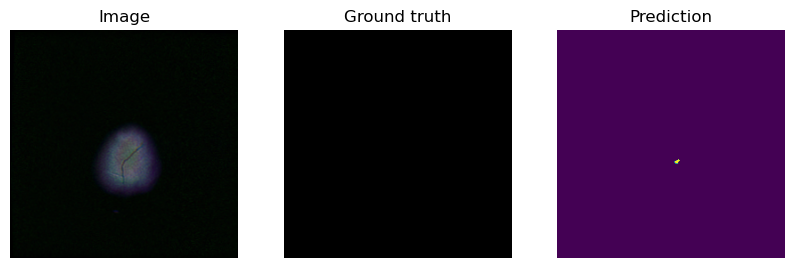

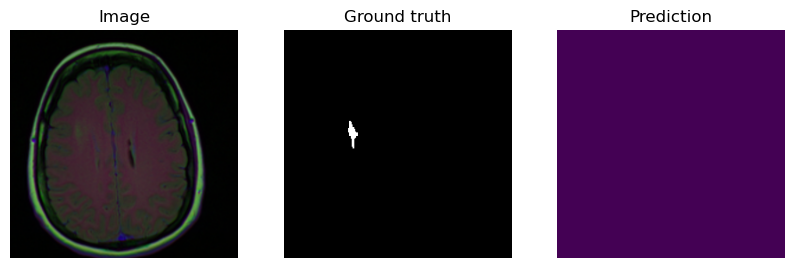

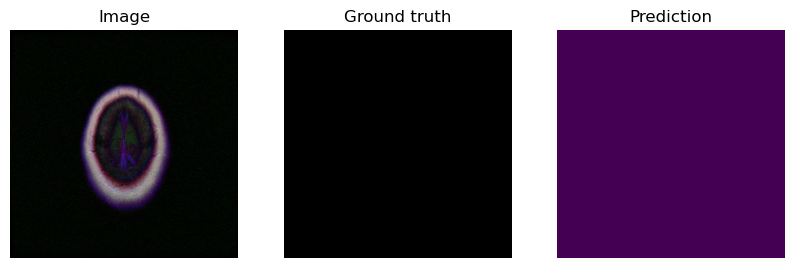

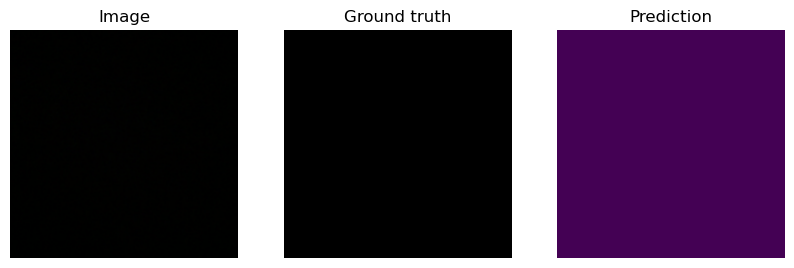

In [46]:
#Predicting the Images
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # we need to squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # we need to squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

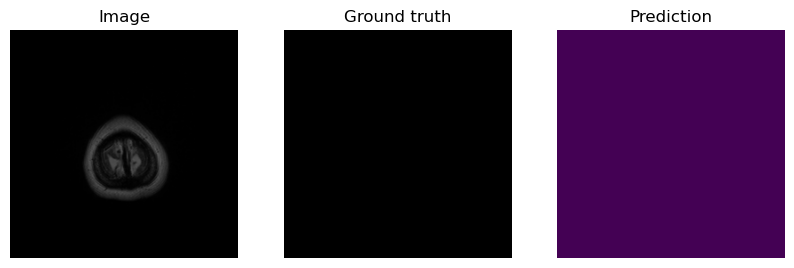

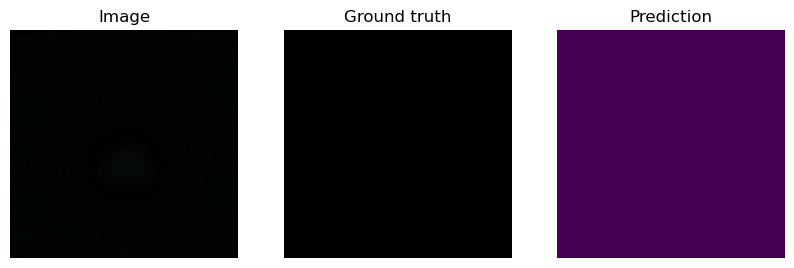

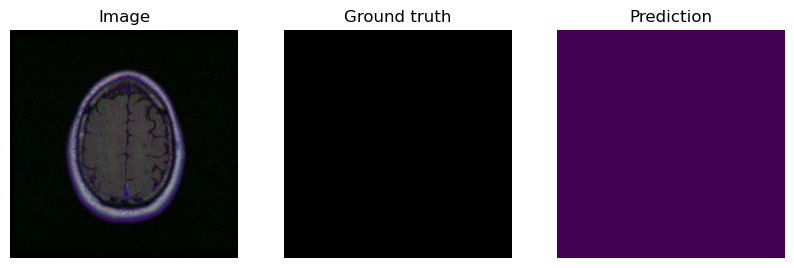

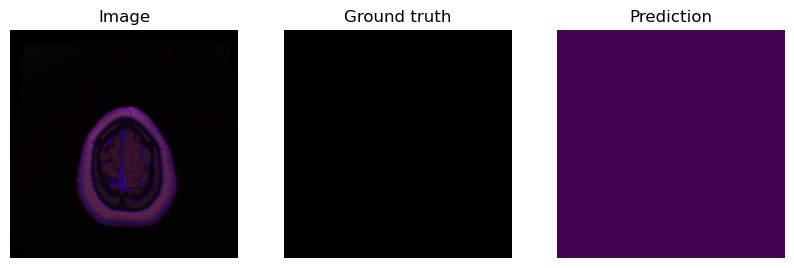

In [47]:
#Predicting the Images
batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # we need to squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # we need to squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [48]:
# model.load_state_dict(torch.load('/kaggle/working/model.bin'))
model.load_state_dict(torch.load('/kaggle/working/model.bin'))

<All keys matched successfully>

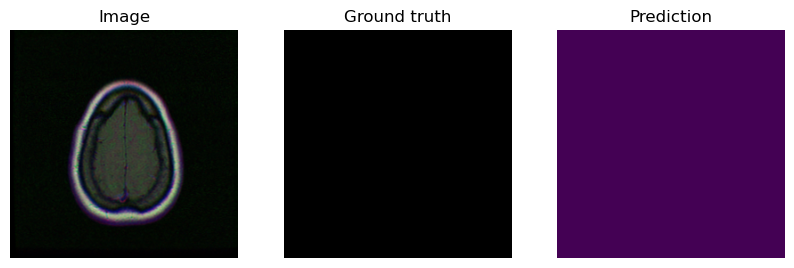

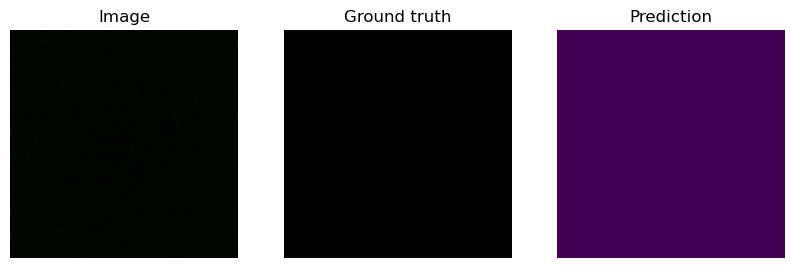

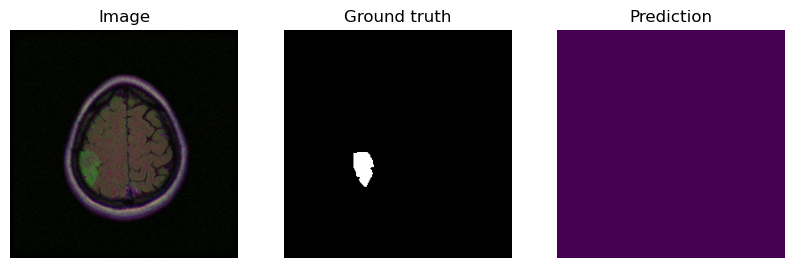

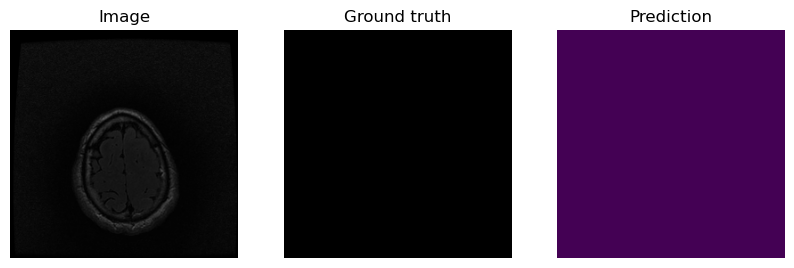

In [49]:

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # we need to squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # we need to squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

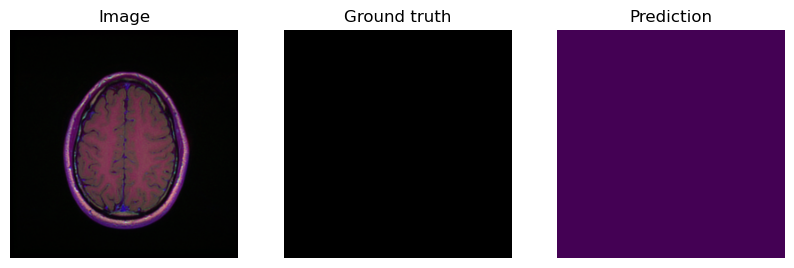

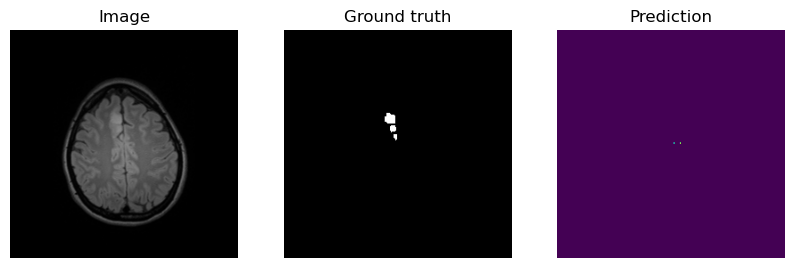

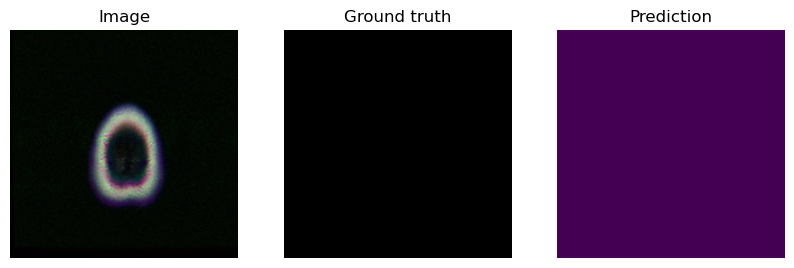

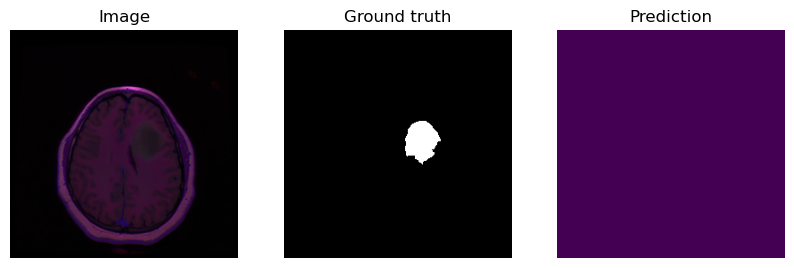

In [50]:

batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # we need to squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # we need to squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

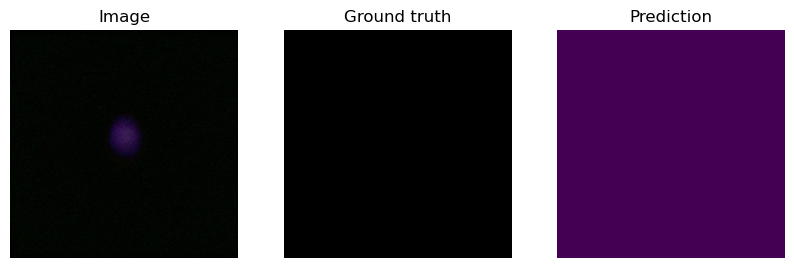

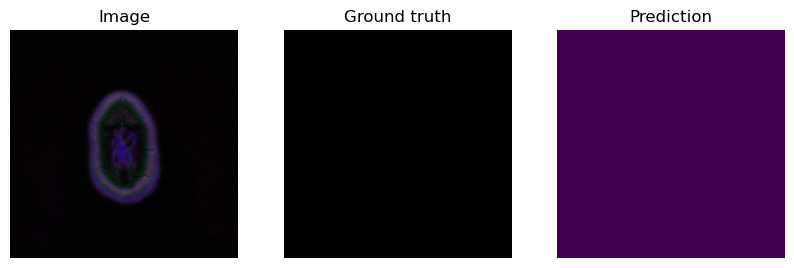

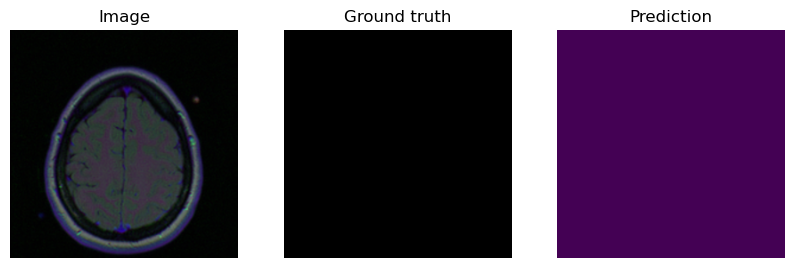

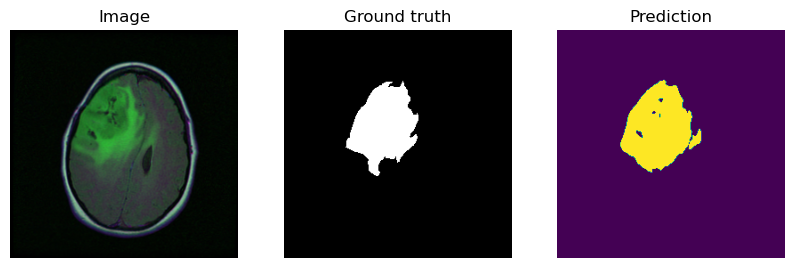

In [52]:


batch = next(iter(test_loader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()


for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # converting CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap = 'gray') # we need to squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.detach().cpu().numpy()) # we need to squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [53]:
@torch.no_grad()
def valid_one_epoch(model = model, 
                    dataloader = test_loader, 
                    loss_fn = loss_fn,
                    device = device, 
                    epoch = 0):
    model.eval() 
    valid_loss, dataset_size = 0,  0
    bar = tqdm(dataloader, total = len(dataloader))
    tp_l, fp_l, fn_l, tn_l = [], [], [], []
    
    with torch.no_grad():
        for data in bar:
            x = data[0].to(device)     
            y_true = data[1].to(device) 
            y_pred = model(x)        
            
            loss = loss_fn(y_pred, y_true)
            
            pred_mask = (y_pred > 0.5).float()
            btp, bfp, bfn, btn = smp.metrics.get_stats(pred_mask.long(), y_true.long(), mode="binary")

            tp_l.append(btp)
            fp_l.append(bfp)
            fn_l.append(bfn)
            tn_l.append(btn)

            tp = torch.cat(tp_l)
            fp = torch.cat(fp_l)
            fn = torch.cat(fn_l)
            tn = torch.cat(tn_l)

            recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")
            precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")

            f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

            # per image IoU means that we first calculate IoU score for each image 
            # and then compute mean over these scores
            per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

            # Dataset IoU means that we aggregate intersection and union over whole dataset
            # and then compute IoU score.
            dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            # valid_epoch_loss 
            bs = x.shape[0]
            dataset_size += bs
            valid_loss += (loss.item() * bs)
            valid_epoch_loss = valid_loss / dataset_size

            bar.set_description(f"EP:{epoch} | VL:{valid_epoch_loss:.3e} | ACC: {accuracy:.2f} | F1: {f1_score:.3f} ")

    metrics =  dict()
    
    metrics['f1_score'] = f1_score.detach().cpu().item()
    metrics['accuracy'] = accuracy.detach().cpu().item()
    
    metrics['recall'] = recall.detach().cpu().item()
    metrics['precision'] = precision.detach().cpu().item()
    
    metrics['dataset_iou'] = dataset_iou.detach().cpu().item()
    metrics['per_iou'] = per_image_iou.detach().cpu().item()
    
    metrics['loss'] = valid_epoch_loss

    return metrics



In [54]:
#Calculating the metrics for test data
test_metrics = valid_one_epoch(model,
                                       dataloader = test_loader,
                                       device = device,
                                       epoch = 1)

EP:1 | VL:4.081e-01 | ACC: 1.00 | F1: 0.633 : 100%|██████████| 197/197 [00:17<00:00, 10.99it/s]


In [55]:
test_metrics

{'f1_score': 0.6332559585571289,
 'accuracy': 0.9953577518463135,
 'recall': 0.5705954432487488,
 'precision': 0.7113764882087708,
 'dataset_iou': 0.46333181858062744,
 'per_iou': 0.7708730697631836,
 'loss': 0.4080837417498193}